# Проект для «Викишоп» с использованием метода BERT.

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.70. 



**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
%pip install transformers
%pip install catboost
%pip install seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import re
import tensorflow as tf
from tqdm import notebook
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle # для перемешивания данных

In [3]:
df = pd.read_csv('/content/drive/MyDrive/toxic_comments.csv')

In [4]:
df.head(20)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Сделаем предобработку текста. Оставим только слова, состоящие из букв.

In [6]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', text).split()
    clear_text = ' '.join(clear_text)
    return(clear_text)

In [7]:
df['text'] = df['text'].apply(clear_text)

In [8]:
df.duplicated().sum()

1146

In [9]:
#удалим дубликаты
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Исследуем соотношение классов.

0   0.898
1   0.102
Name: toxic, dtype: float64


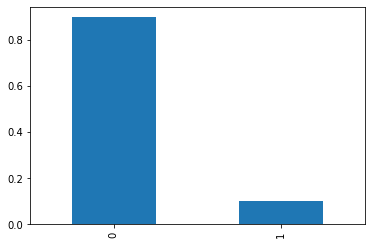

In [18]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Гистограмма показала, что классы не сбалансированы. После подготовки эмбеддингов необходимо будет провести ликвидацию дисбаланса.

Т.к. исходный датасет достаточно велик, для создания его эмбеддингов понадобятся значительные вычислительные мощности. В виду отсутствия данных мощностей, выберем 3000 случайных строк для выполнения проекта с сохранением исходного дисбаланса классов. Чтобы сохранить выявленный дисбаланс классов, применим метод train_test_split.

In [10]:
df_rest, df_1 = train_test_split(df, test_size=3000, random_state=12345)
df_1.shape

(3000, 2)

Проведем токенизацию текстов.

In [11]:
def make_embeddings(features):
    model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

  # Загрузка предобученной модели/токенизатора 
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    tokenized= features.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

    attention_mask = np.where(padded != 0, 1, 0)

    batch_size = 100

    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

    final_features = np.concatenate(embeddings)
    final_features = pd.DataFrame(final_features)
    return final_features

In [12]:
features = make_embeddings(df_1['text'])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/30 [00:00<?, ?it/s]

In [13]:
target = df_1['toxic'].reset_index(drop=True)

In [14]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
features, target, test_size=0.4, stratify=target, random_state=12345) # разделим выборки в пропорции 4 к 10

features_test, features_valid, target_test, target_valid = train_test_split(
features_valid_test, target_valid_test, test_size=0.5, stratify=target_valid_test, random_state=12345) # разделим валидационную и тестовую пополам

In [15]:
print(features_train.shape)
print(features_test.shape)

(1800, 768)
(600, 768)


In [16]:
target_train.value_counts()

0    1615
1     185
Name: toxic, dtype: int64

In [17]:
features_train.shape

(1800, 768)

Напишем функцию для ликвидации дисбаланса классов.

In [19]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [20]:
repeat=10
features_train, target_train = upsample(features_train, target_train, repeat)
print(features_train.shape)
print(target_train.value_counts())

(3465, 768)
1    1850
0    1615
Name: toxic, dtype: int64


## Обучение моделей

Логистическая регрессия

In [21]:
best_model = None
best_result = 0
best_с = 0
for reg in np.linspace(0.0001, 100, 20):
    model = LogisticRegression(random_state=12345, solver='liblinear', C=reg)
    model.fit(features_train, target_train) # обучаем модель на обучающей выборке
    predictions = model.predict(features_valid) # получим предсказания модели на валидационной выборке
    result = f1_score(target_valid, predictions) # посчитаем качество модели
    print(result)
    if result > best_result:
        best_model = model
        best_result = result
        best_с = reg
print('Наилучшее качество модели {:.3f} при регуляризации {}'.format(best_result, best_с))

0.29197080291970795
0.640625
0.6719999999999999
0.6721311475409835
0.6721311475409835
0.6499999999999999
0.6499999999999999
0.6499999999999999
0.6499999999999999
0.639344262295082
0.639344262295082
0.639344262295082
0.639344262295082
0.639344262295082
0.639344262295082
0.639344262295082
0.639344262295082
0.639344262295082
0.639344262295082
0.639344262295082
Наилучшее качество модели 0.672 при регуляризации 15.789557894736841


Наилучшее значение метрики F1 для логистической регрессии на валидационной выборке, равное 0.672, было получено для регуляризации равной 15.789557894736841

Случайный лес

In [22]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
best_split = 0
for est in range(10, 101, 10):
    for depth in range (1, 9):
        for spl in (2, 7):
            model = RandomForestClassifier(random_state=12345, 
                                     n_estimators=est, 
                                     max_depth=depth, min_samples_split = spl)
            model.fit(features_train, target_train) # обучим модель на тренировочной выборке
            predictions = model.predict(features_valid)
            result = f1_score(target_valid, predictions) # посчитаем качество модели на валидационной выборке
            print(result)
            if result > best_result:
                best_model = model
                best_result = result
                best_est = est
                best_depth = depth
                best_split = spl

print("F1 наилучшей модели на валидационной выборке:", best_result, 
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth,
     "Минимальное количество примеров для разделения", best_split)

0.3952569169960474
0.3952569169960474
0.4752475247524752
0.4752475247524752
0.5310734463276836
0.5310734463276836
0.5512820512820513
0.5512820512820513
0.5441176470588236
0.5441176470588236
0.5040650406504066
0.5
0.5504587155963303
0.5321100917431193
0.5666666666666665
0.5737704918032787
0.4383561643835616
0.4383561643835616
0.47916666666666663
0.47916666666666663
0.5301204819277108
0.5301204819277108
0.5562913907284769
0.5562913907284769
0.5874125874125874
0.588235294117647
0.5081967213114755
0.5081967213114755
0.5454545454545454
0.5892857142857142
0.5333333333333333
0.5471698113207547
0.44651162790697674
0.44651162790697674
0.5106382978723405
0.5106382978723405
0.5432098765432098
0.5432098765432098
0.543046357615894
0.543046357615894
0.5985401459854014
0.5925925925925926
0.504201680672269
0.5737704918032787
0.5765765765765767
0.5818181818181819
0.5420560747663551
0.5233644859813085
0.4593301435406698
0.4593301435406698
0.5
0.5
0.5521472392638037
0.5521472392638037
0.5503355704697986


Наилучшее значение метрики F1 для случайного леса, равное 0.603, было получено для следующих параметров: {'max_depth': 8, 'n_estimators': 80, min_samples_split: 7}

LightGBM

In [23]:
best_model = None
best_result = 0
best_est = 0
best_leaves = 0
best_rate = 0
for est in [50, 100, 500]:
    for leave in [21, 31, 41, 51]:
        for rate in [0.01, .04, 0.06, 0.3]:
            model = LGBMClassifier(random_state=12345, 
                                     n_estimators=est, 
                                     num_leaves=leave, learning_rate = rate) 
            model.fit(features_train, target_train) # обучим модель на тренировочной выборке
            predictions = model.predict(features_valid)
            result = f1_score(target_valid, predictions) # посчитаем качество модели на валидационной выборке
            print(result)
            if result > best_result:
                best_model = model
                best_result = result
                best_est = est
                best_leaves = leave
                best_rate = rate

print("F1 наилучшей модели на валидационной выборке:", best_result, 
      "Количество деревьев:", best_est, "Скорость обучения:", best_rate,
     "Количество листьев", best_leaves)

0.537313432835821
0.5641025641025641
0.5794392523364486
0.5591397849462366
0.5147058823529412
0.5233644859813085
0.5148514851485149
0.5473684210526315
0.5271317829457364
0.5384615384615384
0.54
0.5217391304347827
0.53125
0.5294117647058822
0.5825242718446603
0.5494505494505495
0.5573770491803278
0.5523809523809524
0.5148514851485149
0.5652173913043478
0.5225225225225224
0.5742574257425742
0.5858585858585857
0.5319148936170212
0.5420560747663551
0.5625
0.5416666666666666
0.5161290322580645
0.5233644859813085
0.5833333333333333
0.5918367346938775
0.5494505494505495
0.5607476635514019
0.5744680851063829
0.5652173913043478
0.5714285714285714
0.5800000000000001
0.5494505494505495
0.5531914893617021
0.5319148936170212
0.5567010309278351
0.5434782608695652
0.5274725274725275
0.5217391304347827
0.5894736842105264
0.5333333333333333
0.5274725274725275
0.5494505494505495
F1 наилучшей модели на валидационной выборке: 0.5918367346938775 Количество деревьев: 100 Скорость обучения: 0.06 Количество л

Наилучшее значение метрики F1 для LGBM, равное 0.59, было получено для следующих параметров: {'num_leaves': 51, 'n_estimators': 100, 'learning_rate': 0.06}

In [32]:
best_model = None
best_result = 0
best_iter = 0
best_rate = 0
for iter in [150, 500]:
    for rate in [0.01, .04, 0.06, 0.3, 0.5]:
    model = CatBoostClassifier(random_state=12345, 
                                     iterations=iter, learning_rate = rate) 
    model.fit(features_train, target_train) # обучим модель на тренировочной выборке
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions) # посчитаем качество модели на валидационной выборке
    print(result)
    if result > best_result:
        best_model = model
        best_result = result
        best_iter = iter
        best_rate = rate

print("F1 наилучшей модели на валидационной выборке:", best_result, 
      "Количество иттераций:", best_iter, "Скорость обучения:", best_rate)

0:	learn: 0.6839326	total: 458ms	remaining: 1m 8s
1:	learn: 0.6748043	total: 669ms	remaining: 49.5s
2:	learn: 0.6655787	total: 867ms	remaining: 42.5s
3:	learn: 0.6567875	total: 1.08s	remaining: 39.5s
4:	learn: 0.6485010	total: 1.29s	remaining: 37.3s
5:	learn: 0.6403826	total: 1.5s	remaining: 35.9s
6:	learn: 0.6306949	total: 1.71s	remaining: 34.9s
7:	learn: 0.6217079	total: 1.92s	remaining: 34s
8:	learn: 0.6129443	total: 2.11s	remaining: 33.1s
9:	learn: 0.6047363	total: 2.31s	remaining: 32.4s
10:	learn: 0.5963411	total: 2.52s	remaining: 31.9s
11:	learn: 0.5884878	total: 2.74s	remaining: 31.5s
12:	learn: 0.5812915	total: 2.94s	remaining: 31s
13:	learn: 0.5742398	total: 3.15s	remaining: 30.6s
14:	learn: 0.5654887	total: 3.35s	remaining: 30.2s
15:	learn: 0.5584126	total: 3.55s	remaining: 29.7s
16:	learn: 0.5514464	total: 3.76s	remaining: 29.4s
17:	learn: 0.5435688	total: 3.96s	remaining: 29s
18:	learn: 0.5378628	total: 4.16s	remaining: 28.7s
19:	learn: 0.5315813	total: 4.38s	remaining: 28.

Тестирование

In [24]:
# логистическая регрессия
model = LogisticRegression(random_state=12345, solver='liblinear', C=15.789557894736841)
model.fit(features_train, target_train) 
predictions = model.predict(features_test)
f_1 = f1_score(target_test, predictions)
print(f_1)

0.6818181818181818


In [25]:
# случайный лес
model = RandomForestClassifier(random_state=12345, n_estimators=80, max_depth=8, min_samples_split = 7) 
model.fit(features_train, target_train) 
predictions = model.predict(features_test)
f_1 = f1_score(target_test, predictions)
print(f_1) 

0.6890756302521007


In [45]:
# Light GBM
model = LGBMClassifier(random_state=12345,  n_estimators=100, num_leaves=51, learning_rate = 0.06) 
model.fit(features_train, target_train) 
predictions = model.predict(features_test)
f_1 = f1_score(target_test, predictions)
print(f_1) 

0.6666666666666666


In [54]:
# CatBoost
model = CatBoostClassifier(random_state=12345, depth=6, iterations=500, learning_rate = 0.06)
model.fit(features_train, target_train) 
predictions = model.predict(features_test)
f_1 = f1_score(target_test, predictions)
print(f_1) 

0:	learn: 0.6405293	total: 455ms	remaining: 3m 47s
1:	learn: 0.5897433	total: 788ms	remaining: 3m 16s
2:	learn: 0.5430730	total: 1.1s	remaining: 3m 2s
3:	learn: 0.5046926	total: 1.31s	remaining: 2m 42s
4:	learn: 0.4713553	total: 1.51s	remaining: 2m 29s
5:	learn: 0.4361374	total: 1.73s	remaining: 2m 22s
6:	learn: 0.4101337	total: 1.95s	remaining: 2m 17s
7:	learn: 0.3859899	total: 2.15s	remaining: 2m 12s
8:	learn: 0.3599012	total: 2.35s	remaining: 2m 8s
9:	learn: 0.3393525	total: 2.56s	remaining: 2m 5s
10:	learn: 0.3229866	total: 2.77s	remaining: 2m 3s
11:	learn: 0.3074898	total: 2.99s	remaining: 2m 1s
12:	learn: 0.2916358	total: 3.19s	remaining: 1m 59s
13:	learn: 0.2793968	total: 3.4s	remaining: 1m 58s
14:	learn: 0.2669551	total: 3.6s	remaining: 1m 56s
15:	learn: 0.2549428	total: 3.81s	remaining: 1m 55s
16:	learn: 0.2453206	total: 4.02s	remaining: 1m 54s
17:	learn: 0.2341428	total: 4.22s	remaining: 1m 53s
18:	learn: 0.2251586	total: 4.43s	remaining: 1m 52s
19:	learn: 0.2164257	total: 4.

*ВЫВОД:*
Целевая метрика F1 на модели CatBoost состовляет 0.73 и это лучший показатель среди всех моделей.